# UNet Segmentation of Optic Disc and Optic Cup

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.optim import Adam

from GlaucomaDataset import GlaucomaDataset
from unet import UNet

In [4]:
origa_path = os.path.join("..", "data", "ORIGA")
images_path = os.path.join(origa_path, "Images_Square")
masks_path = os.path.join(origa_path, "Masks_Square")

img_filenames = sorted(os.listdir(images_path))
mask_filenames = sorted(os.listdir(masks_path))

In [5]:
# Split into train, validation, and test sets (70, 15, 15)
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    img_filenames, mask_filenames, test_size=0.3, random_state=42)

val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5, random_state=42)

In [6]:
# Set parameters (learning rate, batch size, epochs, etc.)
lr = 1e-4
batch_size = 8
n_workers = 4
epochs = 60

In [7]:
# Load data
train_set = GlaucomaDataset(images_path, masks_path, train_imgs, train_masks)
val_set = GlaucomaDataset(images_path, masks_path, val_imgs, val_masks)
test_set = GlaucomaDataset(images_path, masks_path, test_imgs, test_masks)

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=n_workers, shuffle=True) # need to load test?

In [8]:
# Define metrics (dice coefficient)
def dice_coefficient(targets, preds, smooth=1e-6):
    # preds = (preds > 0.5).float 
    intersection = torch.sum(preds * targets, dim=(2,3))
    # want close to 1 (identical)
    dice = (2. * intersection + smooth) / (torch.sum(preds, dim=(2,3)) + torch.sum(targets, dim=(2,3)) + smooth)
    return dice.mean()

In [9]:
# Initialize model (device, model, loss, optimizer)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1).to(device)
loss_func = torch.nn.BCELoss(reduction='mean')
optimizer = Adam(model.parameters(), lr=lr)

In [8]:
for images, masks in train_loader:
    print(images.shape)
    print(masks.shape)
    break

torch.Size([8, 1, 256, 256])
torch.Size([8, 2, 256, 256])


In [9]:
len(images)

8

#### Train model

In [10]:
train_losses = []
dice_scores = []
model.train()

for epoch in range(epochs):
    train_loss = 0.
    dice = 0.

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = loss_func(output, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        dice += dice_coefficient(output, masks).item()

    train_loss /= len(train_loader)
    dice /= len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Dice: {dice:.4f}")

Epoch 1/60:
Train Loss: 0.2768, Train Dice: 0.0099
Epoch 2/60:
Train Loss: 0.0319, Train Dice: 0.1719
Epoch 3/60:
Train Loss: 0.0243, Train Dice: 0.3118
Epoch 4/60:
Train Loss: 0.0225, Train Dice: 0.3641
Epoch 5/60:
Train Loss: 0.0206, Train Dice: 0.4085
Epoch 6/60:
Train Loss: 0.0162, Train Dice: 0.5391
Epoch 7/60:
Train Loss: 0.0124, Train Dice: 0.6222
Epoch 8/60:
Train Loss: 0.0097, Train Dice: 0.6841
Epoch 9/60:
Train Loss: 0.0089, Train Dice: 0.7070
Epoch 10/60:
Train Loss: 0.0080, Train Dice: 0.7282
Epoch 11/60:
Train Loss: 0.0074, Train Dice: 0.7405
Epoch 12/60:
Train Loss: 0.0076, Train Dice: 0.7353
Epoch 13/60:
Train Loss: 0.0067, Train Dice: 0.7652
Epoch 14/60:
Train Loss: 0.0069, Train Dice: 0.7624
Epoch 15/60:
Train Loss: 0.0069, Train Dice: 0.7678
Epoch 16/60:
Train Loss: 0.0064, Train Dice: 0.7701
Epoch 17/60:
Train Loss: 0.0060, Train Dice: 0.7845
Epoch 18/60:
Train Loss: 0.0059, Train Dice: 0.7929
Epoch 19/60:
Train Loss: 0.0058, Train Dice: 0.7899
Epoch 20/60:
Train Lo

In [12]:
# Save trained model for future reference
torch.save(model.state_dict(), 'model_state_dict.pth')

#### Evaluate on one image in validation set

In [138]:
# Load in model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1).to(device)
path = os.path.join(os.getcwd(), "model_state_dict.pth")
model.load_state_dict(torch.load(path, weights_only=True))

<All keys matched successfully>

In [139]:
model.eval()

val_iter = iter(val_loader)
image_batch, mask_batch = next(val_iter)

# Get first image/mask in batch
image = image_batch[0] # (1, 256, 256)
mask = mask_batch[0] # (2, 256, 256)

# Add batch dimension 
image = image.unsqueeze(0).to(device) # (1, 1, 256, 256)
mask = mask.to(device)

In [140]:
# Predict on image
with torch.no_grad():
    pred = model(image) # (1, 2, 256, 256)

In [141]:
od_loss = loss(pred[0][0], mask[0])
oc_loss = loss(pred[0][1], mask[1])

print(f"Optic Disc Loss: {od_loss}")
print(f"Optic Cup Loss: {oc_loss}")

Optic Disc Loss: 0.0031576743349432945
Optic Cup Loss: 0.0031811383087188005


In [142]:
# Remove batch dimension
pred = pred.squeeze(0).cpu().numpy()
mask = mask.cpu().numpy()

# Get binary masks for optic disc/cup
pred_od = pred[0]
pred_oc = pred[1]

# Threshold for binary segmentation
pred_od = (pred_od > 0.5).astype(int)
pred_oc = (pred_oc > 0.5).astype(int)

In [143]:
# Accuracy
od_accuracy = np.sum(pred_od == mask[0]) / mask[0].size
oc_accuracy = np.sum(pred_oc == mask[1]) / mask[1].size

print(f"OD Accuracy: {od_accuracy}")
print(f"OC Accuracy: {oc_accuracy}")

OD Accuracy: 0.9986419677734375
OC Accuracy: 0.99847412109375


Text(0.5, 1.0, 'Predicted Masks')

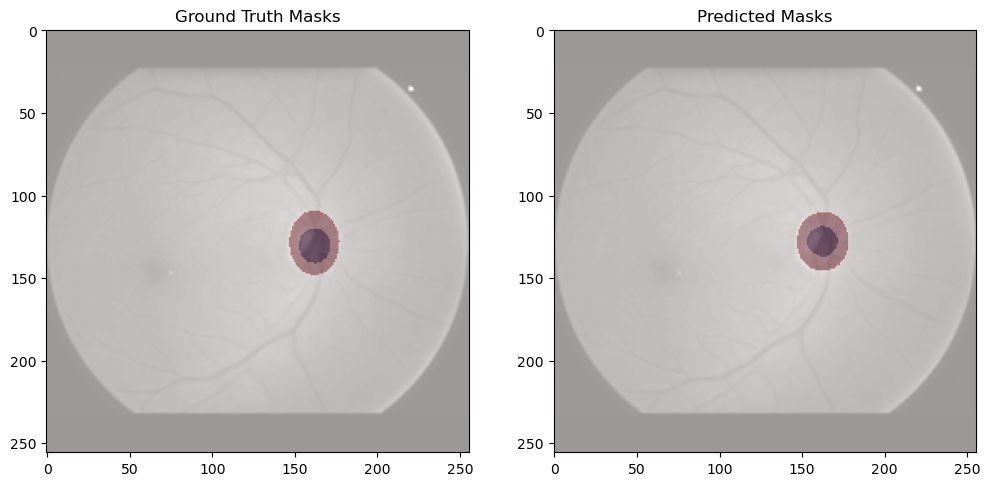

In [148]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

color_mask = np.zeros_like(image.squeeze().cpu().numpy())
color_mask[mask[0] == 1] = 255
od_mask = color_mask

color_mask = np.zeros_like(image.squeeze().cpu().numpy())
color_mask[mask[1] == 1] = 255
oc_mask = color_mask

color_mask = np.zeros_like(image.squeeze().cpu().numpy())
color_mask[pred_od == 1] = 255
od_mask_pred = color_mask

color_mask = np.zeros_like(image.squeeze().cpu().numpy())
color_mask[pred_oc == 1] = 255
oc_mask_pred = color_mask

ax[0].imshow(image.squeeze().cpu().numpy(), cmap='gray')
ax[0].imshow(od_mask, cmap='Reds', alpha=0.5)
ax[0].imshow(oc_mask, cmap='Blues', alpha=0.25)
ax[0].set_title("Ground Truth Masks")

ax[1].imshow(image.squeeze().cpu().numpy(), cmap='gray')
ax[1].imshow(od_mask_pred, cmap='Reds', alpha=0.5)
ax[1].imshow(oc_mask_pred, cmap='Blues', alpha=0.25)
ax[1].set_title("Predicted Masks")

In [2]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(image.squeeze().cpu().numpy(), gray='gray')
ax[0].set_title("Input Image")

ax[1].imshow(mask[0], cmap='gray')  # Ground Truth Optic Disc
ax[1].set_title("Ground Truth Mask (OD)")

ax[2].imshow(pred_od, cmap='gray')  # Predicted Optic Disc
ax[2].set_title("Predicted Mask (OD)")

plt.show()

NameError: name 'plt' is not defined

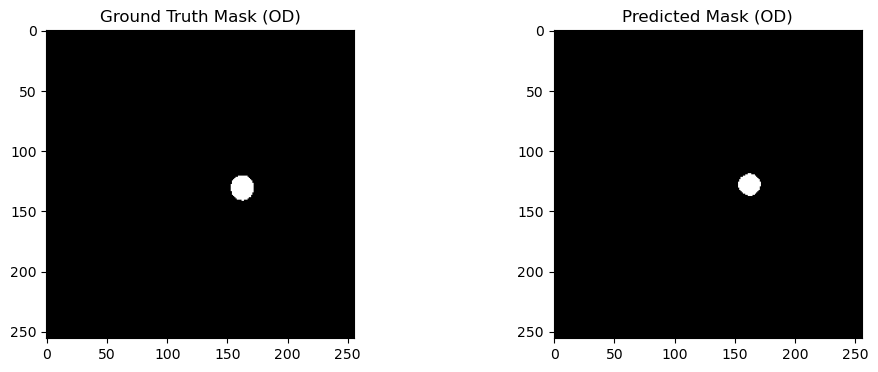

In [150]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].imshow(mask[1], cmap='gray')  # Ground Truth Optic Disc
ax[0].set_title("Ground Truth Mask (OD)")

ax[1].imshow(pred_oc, cmap='gray')  # Predicted Optic Disc
ax[1].set_title("Predicted Mask (OD)")

plt.show()

In [155]:
# Next image:

image = image_batch[1]
mask = mask_batch[1]
image = image.unsqueeze(0).to(device)
mask = mask.to(device)

with torch.no_grad():
    pred = model(image)

od_loss = loss(pred[0][0], mask[0])
oc_loss = loss(pred[0][1], mask[1])

print(f"Optic Disc Loss: {od_loss}")
print(f"Optic Cup Loss: {oc_loss}")

Optic Disc Loss: 0.011547568254172802
Optic Cup Loss: 0.0030237382743507624


In [156]:
pred = pred.squeeze(0).cpu().numpy()
mask = mask.cpu().numpy()
pred_od = pred[0]
pred_oc = pred[1]

pred_od = (pred_od > 0.5).astype(int)
pred_oc = (pred_oc > 0.5).astype(int)

In [157]:
# Accuracy
od_accuracy = np.sum(pred_od == mask[0]) / mask[0].size
oc_accuracy = np.sum(pred_oc == mask[1]) / mask[1].size

print(f"OD Accuracy: {od_accuracy}")
print(f"OC Accuracy: {oc_accuracy}")

OD Accuracy: 0.9961090087890625
OC Accuracy: 0.9987030029296875


Text(0.5, 1.0, 'Predicted Masks')

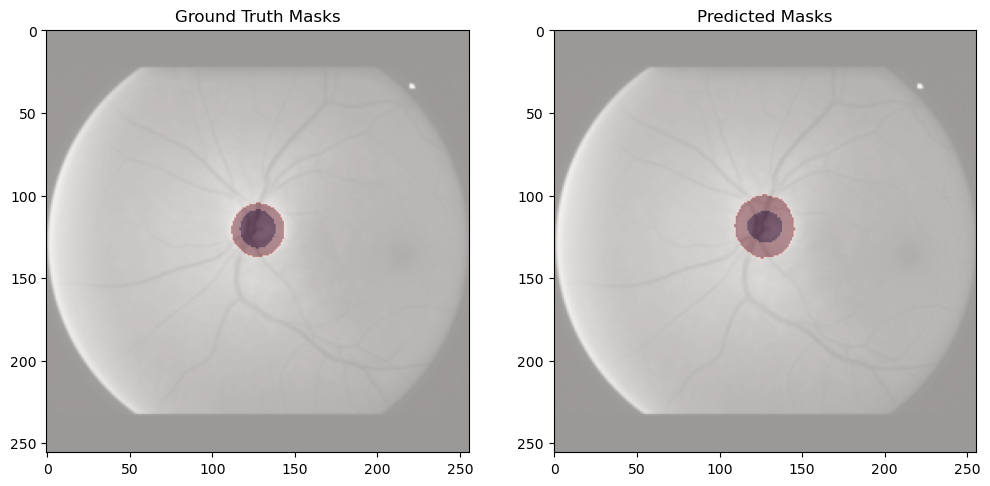

In [159]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

color_mask = np.zeros_like(image.squeeze().cpu().numpy())
color_mask[mask[0] == 1] = 255
od_mask = color_mask

color_mask = np.zeros_like(image.squeeze().cpu().numpy())
color_mask[mask[1] == 1] = 255
oc_mask = color_mask

color_mask = np.zeros_like(image.squeeze().cpu().numpy())
color_mask[pred_od == 1] = 255
od_mask_pred = color_mask

color_mask = np.zeros_like(image.squeeze().cpu().numpy())
color_mask[pred_oc == 1] = 255
oc_mask_pred = color_mask

ax[0].imshow(image.squeeze().cpu().numpy(), cmap='gray')
ax[0].imshow(od_mask, cmap='Reds', alpha=0.5)
ax[0].imshow(oc_mask, cmap='Blues', alpha=0.25)
ax[0].set_title("Ground Truth Masks")

ax[1].imshow(image.squeeze().cpu().numpy(), cmap='gray')
ax[1].imshow(od_mask_pred, cmap='Reds', alpha=0.5)
ax[1].imshow(oc_mask_pred, cmap='Blues', alpha=0.25)
ax[1].set_title("Predicted Masks")

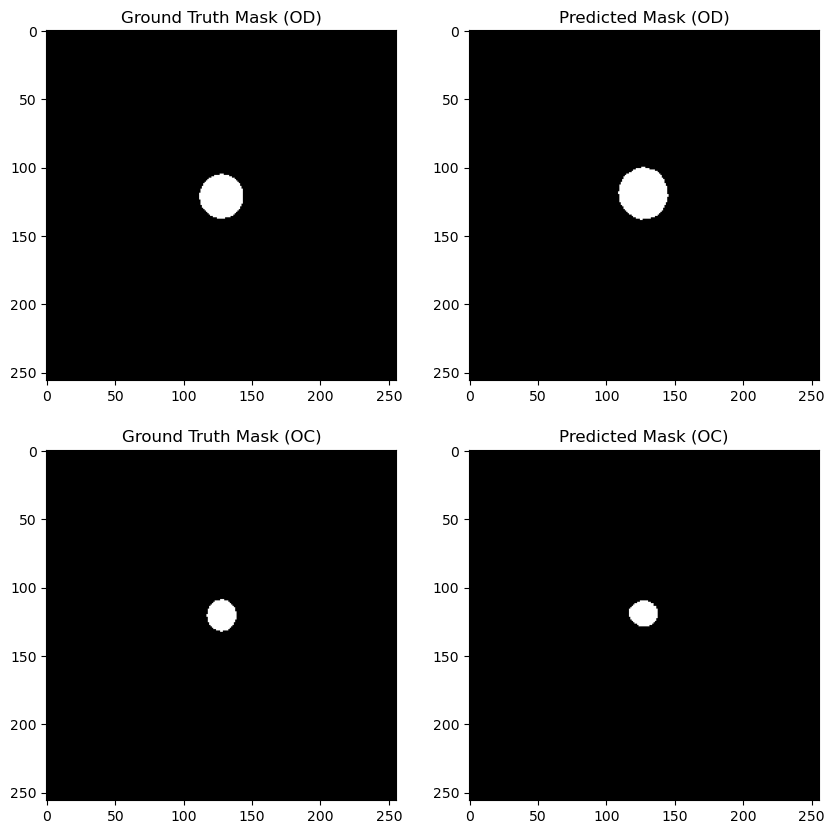

In [160]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0,0].imshow(mask[0], cmap='gray')
ax[0,0].set_title("Ground Truth Mask (OD)")

ax[0,1].imshow(pred_od, cmap='gray')
ax[0,1].set_title("Predicted Mask (OD)")

ax[1,0].imshow(mask[1], cmap='gray')
ax[1,0].set_title("Ground Truth Mask (OC)")

ax[1,1].imshow(pred_oc, cmap='gray')
ax[1,1].set_title("Predicted Mask (OC)")

plt.show()

In [ ]:
#img_path = os.path.join(images_path, val_set.img_filenames[2])
#plt.imshow(Image.open(img_path))

In [ ]:
# To consider: adding grayscale / normalization (either for images or batches), adding a remove nerves function
# Implement early stopping?

In [ ]:
# TODO: Tune model (cv for lr, epochs, batch size, etc.)